In [1]:
import pydicom as dcm
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import random
import seaborn as sns

from sklearn import linear_model

In [2]:
mypath = 'E:/OSIC-Pul/'
train = pd.read_csv(mypath + 'train.csv')
test = pd.read_csv(mypath + 'test.csv')
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB
None


In [3]:
print("Train:")
train

Train:


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


In [4]:
print("Test:")
print("{} rows by {} columns.\n" .format(test.shape[0], test.shape[1]))
test

Test:
5 rows by 7 columns.



,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [5]:
print("Does Train contain any empty values?")
print(train.isnull().sum())

Does Train contain any empty values?
Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64


In [6]:
print("Unique patients in Train:")
print(len(train['Patient'].unique()))

Unique patients in Train:
176


In [7]:
print("Min age:",train['Age'].min(),"\nMax age: ", train['Age'].max())
print("Min FVC: ",train['FVC'].min(),"\nMax FVC: ",train['FVC'].max())
print("Min Weeks: ",train['Weeks'].min(),"\nMax Weeks: ",train['Weeks'].max())

Min age: 49 
Max age:  88
Min FVC:  827 
Max FVC:  6399
Min Weeks:  -5 
Max Weeks:  133


In [8]:
trainNoDupe = train[['Patient', 'Age', 'Sex', 'SmokingStatus']].drop_duplicates().reset_index(drop=True)
trainNoDupe.head()

,Patient,Age,Sex,SmokingStatus
0,ID00007637202177411956430,79,Male,Ex-smoker
1,ID00009637202177434476278,69,Male,Ex-smoker
2,ID00010637202177584971671,60,Male,Ex-smoker
3,ID00011637202177653955184,72,Male,Ex-smoker
4,ID00012637202177665765362,65,Male,Never smoked


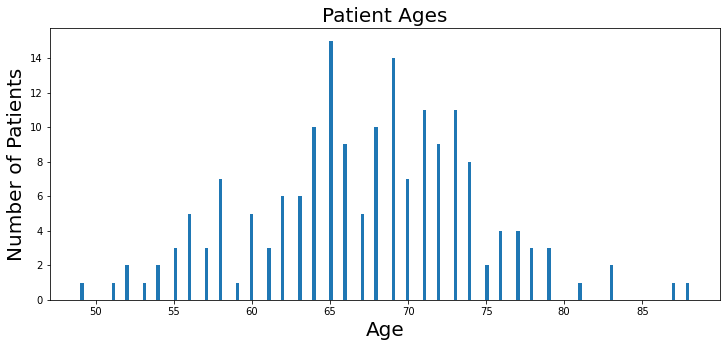

In [9]:
plt.figure(figsize=(12,5))
plt.hist(trainNoDupe.Age, bins=len(trainNoDupe))
plt.xticks()
plt.ylabel('Number of Patients', fontsize=20)
plt.xlabel('Age', fontsize=20)
plt.title('Patient Ages', fontsize=20)
plt.show()

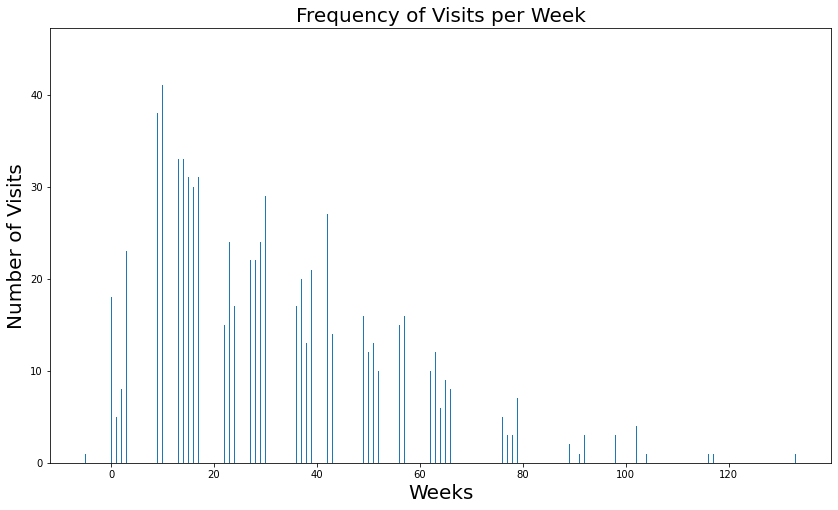

In [10]:
plt.figure(figsize=(14,8))
plt.hist(train.Weeks, bins=len(train))
plt.xticks()
plt.ylabel('Number of Visits', fontsize=20)
plt.xlabel('Weeks', fontsize=20)
plt.title('Frequency of Visits per Week', fontsize=20)
plt.show()

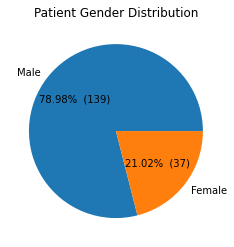

In [11]:
genderCount = trainNoDupe.groupby('Patient')['Sex'].first().value_counts()
total = sum(genderCount)
sizes = [len(trainNoDupe[trainNoDupe.Sex == 'Male']), len(trainNoDupe[trainNoDupe.Sex == 'Female'])]
labels = ['Male', 'Female']
values = [genderCount['Male'], genderCount['Female']]
plt.pie(sizes, labels=labels, autopct=lambda p : '{:.2f}%  ({:.0f})'.format(p, p*total/100))
plt.title("Patient Gender Distribution")
plt.show()

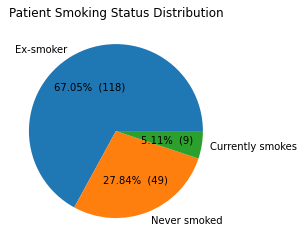

In [12]:
smokeCount = trainNoDupe.groupby('Patient')['SmokingStatus'].first().value_counts()
total = sum(smokeCount)
labels = ['Ex-smoker', 'Never smoked', 'Currently smokes']
sizes = [len(trainNoDupe[trainNoDupe.SmokingStatus == labels[0]]), len(trainNoDupe[trainNoDupe.SmokingStatus == labels[1]]), len(trainNoDupe[trainNoDupe.SmokingStatus == labels[2]])]
plt.pie(sizes, labels=labels, autopct=lambda p : '{:.2f}%  ({:.0f})'.format(p, p*total/100))
plt.title("Patient Smoking Status Distribution")
plt.show()

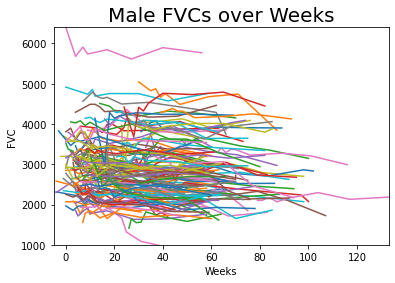

Number of people who got better: 24/139
Percent of people who got better: 17%


In [13]:
gradients = []
linreg = linear_model.LinearRegression()

for patient, info in list(train.groupby('Patient')):
    if info.iloc[0]['Sex'] == 'Male':
        linreg.fit(info[['Weeks']], info[['FVC']])
        gradients.append(linreg.coef_[0][0])
        plt.plot(info[['Weeks', 'FVC']].set_index('Weeks'))
        plt.axis((-5,133,1000,6399))
        plt.ylabel('FVC')
        plt.xlabel('Weeks')
        plt.title('Male FVCs over Weeks', fontsize=20)
        
better = np.sum(np.array(gradients) >= 0, axis=0)
total = trainNoDupe.groupby('Patient')['Sex'].first().value_counts()['Male']
plt.show()
print("Number of people who got better: {}/{}".format(better,total))
print("Percent of people who got better: {0:.0%}".format(better/total))


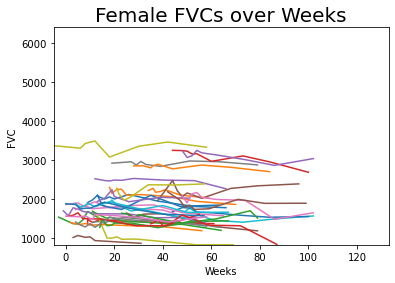

Number of people who got better: 5/37
Percent of people who got better: 14%


In [14]:
gradients = []
linreg = linear_model.LinearRegression()

for patient, info in list(train.groupby('Patient')):
    if info.iloc[0]['Sex'] == 'Female':
        linreg.fit(info[['Weeks']], info[['FVC']])
        gradients.append(linreg.coef_[0][0])
        plt.plot(info[['Weeks', 'FVC']].set_index('Weeks'))
        plt.axis((-5,133,827,6399))
        plt.ylabel('FVC')
        plt.xlabel('Weeks')
        plt.title('Female FVCs over Weeks', fontsize=20)
        
better = np.sum(np.array(gradients) >= 0, axis=0)
total = trainNoDupe.groupby('Patient')['Sex'].first().value_counts()['Female']
plt.show()
print("Number of people who got better: {}/{}".format(better,total))
print("Percent of people who got better: {0:.0%}".format(better/total))

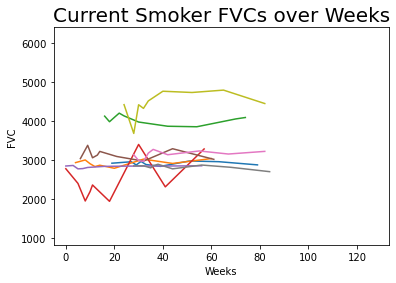

Number of people who got better: 5/9
Percent of people who got better: 56%


In [15]:
gradients = []
linreg = linear_model.LinearRegression()

for patient, info in list(train.groupby('Patient')):
    if info.iloc[0]['SmokingStatus'] == 'Currently smokes':
        linreg.fit(info[['Weeks']], info[['FVC']])
        gradients.append(linreg.coef_[0][0])
        plt.plot(info[['Weeks', 'FVC']].set_index('Weeks'))
        plt.axis((-5,133,827,6399))
        plt.ylabel('FVC')
        plt.xlabel('Weeks')
        plt.title('Current Smoker FVCs over Weeks', fontsize=20)
        
better = np.sum(np.array(gradients) >= 0, axis=0)
total = trainNoDupe.groupby('Patient')['SmokingStatus'].first().value_counts()['Currently smokes']
plt.show()
print("Number of people who got better: {}/{}".format(better,total))
print("Percent of people who got better: {0:.0%}".format(better/total))

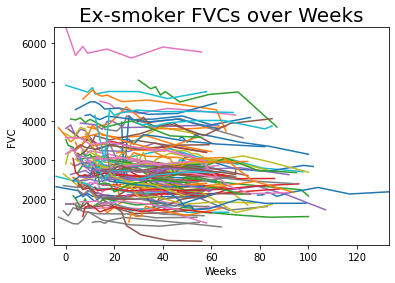

Number of people who got better: 18/118
Percent of people who got better: 15%


In [16]:
gradients = []
linreg = linear_model.LinearRegression()

for patient, info in list(train.groupby('Patient')):
    if info.iloc[0]['SmokingStatus'] == 'Ex-smoker':
        linreg.fit(info[['Weeks']], info[['FVC']])
        gradients.append(linreg.coef_[0][0])
        plt.plot(info[['Weeks', 'FVC']].set_index('Weeks'))
        plt.axis((-5,133,827,6399))
        plt.ylabel('FVC')
        plt.xlabel('Weeks')
        plt.title('Ex-smoker FVCs over Weeks', fontsize=20)
        
better = np.sum(np.array(gradients) >= 0, axis=0)
total = trainNoDupe.groupby('Patient')['SmokingStatus'].first().value_counts()['Ex-smoker']
plt.show()
print("Number of people who got better: {}/{}".format(better,total))
print("Percent of people who got better: {0:.0%}".format(better/total))

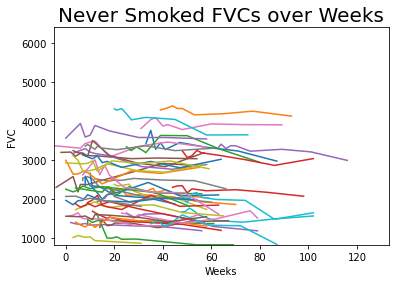

Number of people who got better: 6/49
Percent of people who got better: 12%


In [17]:
gradients = []
linreg = linear_model.LinearRegression()

for patient, info in list(train.groupby('Patient')):
    if info.iloc[0]['SmokingStatus'] == 'Never smoked':
        linreg.fit(info[['Weeks']], info[['FVC']])
        gradients.append(linreg.coef_[0][0])
        plt.plot(info[['Weeks', 'FVC']].set_index('Weeks'))
        plt.axis((-5,133,827,6399))
        plt.ylabel('FVC')
        plt.xlabel('Weeks')
        plt.title('Never Smoked FVCs over Weeks', fontsize=20)
        
better = np.sum(np.array(gradients) >= 0, axis=0)
total = trainNoDupe.groupby('Patient')['SmokingStatus'].first().value_counts()['Never smoked']
plt.show()
print("Number of people who got better: {}/{}".format(better,total))
print("Percent of people who got better: {0:.0%}".format(better/total))

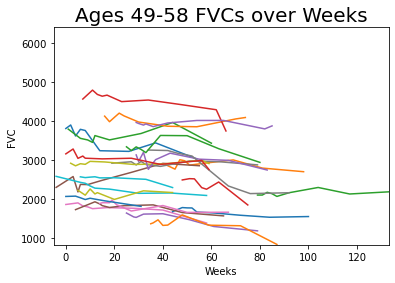

Number of people who got better: 4/25
Percent of people who got better: 16%


In [18]:
gradients = []
linreg = linear_model.LinearRegression()
age4958 = []
FVCarray = []
total = 0
for patient, info in list(train.groupby('Patient')):
    if info.iloc[0]['Age'] in range(49,59):
        total += 1
        for i in range(len(info)):
            FVCarray.append(info.iloc[i]['FVC'])
        mean = sum(FVCarray)/len(FVCarray)
        age4958.append(mean)
        FVCarray = []
        linreg.fit(info[['Weeks']], info[['FVC']])
        gradients.append(linreg.coef_[0][0])
        plt.plot(info[['Weeks', 'FVC']].set_index('Weeks'))
        plt.axis((-5,133,827,6399))
        plt.ylabel('FVC')
        plt.xlabel('Weeks')
        plt.title('Ages 49-58 FVCs over Weeks', fontsize=20)

better = np.sum(np.array(gradients) >= 0, axis=0)
plt.show()
print("Number of people who got better: {}/{}".format(better,total))
print("Percent of people who got better: {0:.0%}".format(better/total))
better4 = better

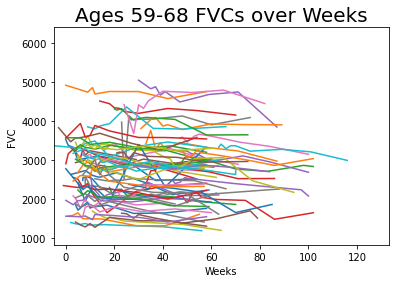

Number of people who got better: 10/70
Percent of people who got better: 14%


In [19]:
gradients = []
linreg = linear_model.LinearRegression()
age5968 = []
FVCarray = []
total = 0
for patient, info in list(train.groupby('Patient')):
    if info.iloc[0]['Age'] in range(59,69):
        total += 1
        for i in range(len(info)):
            FVCarray.append(info.iloc[i]['FVC'])
        mean = sum(FVCarray)/len(FVCarray)
        age5968.append(mean)
        FVCarray = []
        linreg.fit(info[['Weeks']], info[['FVC']])
        gradients.append(linreg.coef_[0][0])
        plt.plot(info[['Weeks', 'FVC']].set_index('Weeks'))
        plt.axis((-5,133,827,6399))
        plt.ylabel('FVC')
        plt.xlabel('Weeks')
        plt.title('Ages 59-68 FVCs over Weeks', fontsize=20)

better = np.sum(np.array(gradients) >= 0, axis=0)
plt.show()
print("Number of people who got better: {}/{}".format(better,total))
print("Percent of people who got better: {0:.0%}".format(better/total))
better5 = better

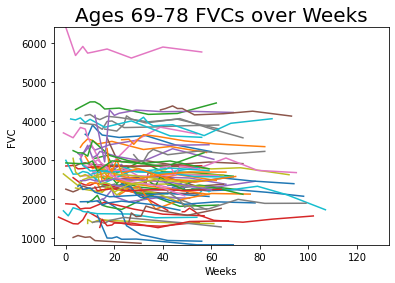

Number of people who got better: 13/73
Percent of people who got better: 18%


In [20]:
gradients = []
linreg = linear_model.LinearRegression()
age6978 = []
FVCarray = []
total = 0
for patient, info in list(train.groupby('Patient')):
    if info.iloc[0]['Age'] in range(69,79):
        total += 1
        for i in range(len(info)):
            FVCarray.append(info.iloc[i]['FVC'])
        mean = sum(FVCarray)/len(FVCarray)
        age6978.append(mean)
        FVCarray = []
        linreg.fit(info[['Weeks']], info[['FVC']])
        gradients.append(linreg.coef_[0][0])
        plt.plot(info[['Weeks', 'FVC']].set_index('Weeks'))
        plt.axis((-5,133,827,6399))
        plt.ylabel('FVC')
        plt.xlabel('Weeks')
        plt.title('Ages 69-78 FVCs over Weeks', fontsize=20)

better = np.sum(np.array(gradients) >= 0, axis=0)
plt.show()
print("Number of people who got better: {}/{}".format(better,total))
print("Percent of people who got better: {0:.0%}".format(better/total))
better6 = better

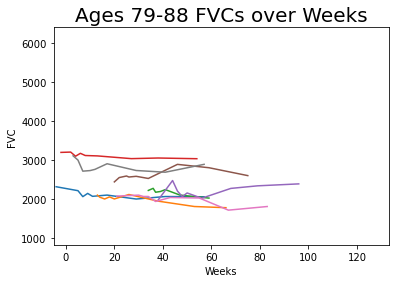

Number of people who got better: 2/8
Percent of people who got better: 25%


In [21]:
gradients = []
linreg = linear_model.LinearRegression()
age7988 = []
FVCarray = []
total = 0
for patient, info in list(train.groupby('Patient')):
    if info.iloc[0]['Age'] in range(79,89):
        total += 1
        for i in range(len(info)):
            FVCarray.append(info.iloc[i]['FVC'])
        mean = sum(FVCarray)/len(FVCarray)
        age7988.append(mean)
        FVCarray = []
        linreg.fit(info[['Weeks']], info[['FVC']])
        gradients.append(linreg.coef_[0][0])
        plt.plot(info[['Weeks', 'FVC']].set_index('Weeks'))
        plt.axis((-5,133,827,6399))
        plt.ylabel('FVC')
        plt.xlabel('Weeks')
        plt.title('Ages 79-88 FVCs over Weeks', fontsize=20)

better = np.sum(np.array(gradients) >= 0, axis=0)
plt.show()
print("Number of people who got better: {}/{}".format(better,total))
print("Percent of people who got better: {0:.0%}".format(better/total))
better7 = better

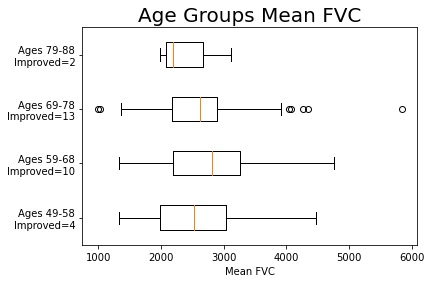

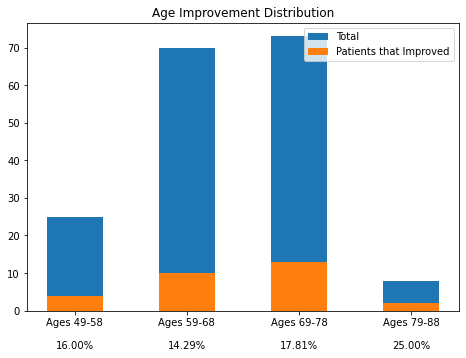

In [22]:
data = [age4958, age5968, age6978, age7988]
labels = ['Ages 49-58\n', 'Ages 59-68\n', 'Ages 69-78\n', 'Ages 79-88\n']
better = [better4, better5, better6, better7]
plot = plt.figure()
ax = plot.add_subplot()
boxplot = ax.boxplot(data, vert=False)
ax.set_yticklabels(['%sImproved=%d'%(labels[i],better[i]) for i in range(4)])
ax.set_title('Age Groups Mean FVC', fontsize=20)
ax.set_xlabel('Mean FVC')
plt.show()

datalen = [len(age4958), len(age5968), len(age6978), len(age7988)]
figure = plt.figure()
ax = figure.add_axes([0,0,1,1])
ax.bar(['%s\n%.2f%%'%(labels[i],better[i]*100/datalen[i]) for i in range(4)], datalen, 0.5)
ax.bar(['%s\n%.2f%%'%(labels[i],better[i]*100/datalen[i]) for i in range(4)], better, 0.5)
ax.legend(labels=['Total', 'Patients that Improved'])
plt.title("Age Improvement Distribution")
plt.show()

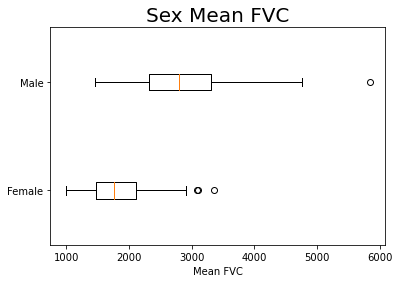

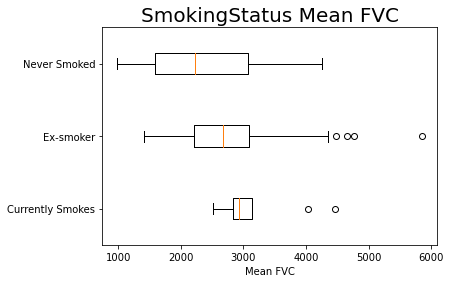

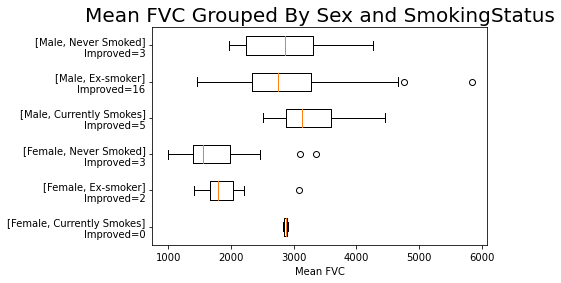

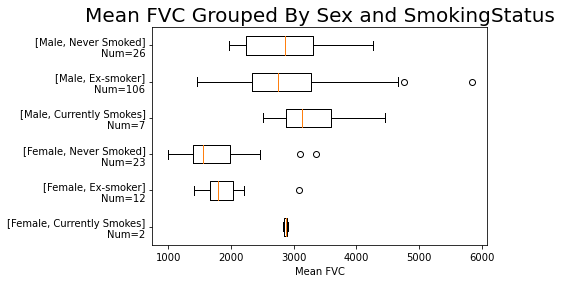

In [24]:
linreg = linear_model.LinearRegression()
MaleC, MaleE, MaleN, FemaleC, FemaleE, FemaleN = ([] for i in range(6))
MCbetter, MEbetter, MNbetter, FCbetter, FEbetter, FNbetter = (0 for i in range(6))
FVCarray = []
for patient, info in list(train.groupby('Patient')):
    linreg.fit(info[['Weeks']], info[['FVC']])
    for i in range(len(info)):
        FVCarray.append(info.iloc[i]['FVC'])
    mean = sum(FVCarray)/len(FVCarray)
    if info.iloc[0]['Sex'] == 'Male':
        if info.iloc[0]['SmokingStatus'] == 'Currently smokes':
            MaleC.append(mean)
            if linreg.coef_[0][0] >= 0:
                MCbetter += 1
        elif info.iloc[0]['SmokingStatus'] == 'Ex-smoker':
            MaleE.append(mean)
            if linreg.coef_[0][0] >= 0:
                MEbetter += 1
        else:
            MaleN.append(mean)
            if linreg.coef_[0][0] >= 0:
                MNbetter += 1
    else:
        if info.iloc[0]['SmokingStatus'] == 'Currently smokes':
            FemaleC.append(mean)
            if linreg.coef_[0][0] >= 0:
                FCbetter += 1
        elif info.iloc[0]['SmokingStatus'] == 'Ex-smoker':
            FemaleE.append(mean)
            if linreg.coef_[0][0] >= 0:
                FEbetter += 1
        else:
            FemaleN.append(mean)
            if linreg.coef_[0][0] >= 0:
                FNbetter += 1
    FVCarray = []

data = [FemaleC+FemaleE+FemaleN, MaleC+MaleE+MaleN]
plot = plt.figure()
ax = plot.add_subplot()
boxplot = ax.boxplot(data, vert=False)
ax.set_yticklabels(['Female', 'Male'])
ax.set_title('Sex Mean FVC', fontsize=20)
ax.set_xlabel('Mean FVC')
plt.show()

data = [FemaleC+MaleC, FemaleE+MaleE, FemaleN+MaleN]
plot = plt.figure()
ax = plot.add_subplot()
boxplot = ax.boxplot(data, vert=False)
ax.set_yticklabels(['Currently Smokes', 'Ex-smoker', 'Never Smoked'])
ax.set_title('SmokingStatus Mean FVC', fontsize=20)
ax.set_xlabel('Mean FVC')
plt.show()

data = [FemaleC, FemaleE, FemaleN, MaleC, MaleE, MaleN]
better = [FCbetter, FEbetter, FNbetter, MCbetter, MEbetter, MNbetter]
labels = ['[Female, Currently Smokes]\n', '[Female, Ex-smoker]\n', '[Female, Never Smoked]\n', \
          '[Male, Currently Smokes]\n', '[Male, Ex-smoker]\n', '[Male, Never Smoked]\n', ]
datalen = [len(FemaleC), len(FemaleE), len(FemaleN), len(MaleC), len(MaleE), len(MaleN)]
plot = plt.figure()
ax = plot.add_subplot()
boxplot = ax.boxplot(data, vert=False)
ax.set_yticklabels(['%sImproved=%d'%(labels[i],better[i]) for i in range(6)])
ax.set_title('Mean FVC Grouped By Sex and SmokingStatus', fontsize=20)
ax.set_xlabel('Mean FVC')
plt.show()

data = [FemaleC, FemaleE, FemaleN, MaleC, MaleE, MaleN]
labels = ['[Female, Currently Smokes]\n', '[Female, Ex-smoker]\n', '[Female, Never Smoked]\n', \
          '[Male, Currently Smokes]\n', '[Male, Ex-smoker]\n', '[Male, Never Smoked]\n', ]
better = [FCbetter, FEbetter, FNbetter, MCbetter, MEbetter, MNbetter]
plot = plt.figure()
ax = plot.add_subplot()
boxplot = ax.boxplot(data, vert=False)
ax.set_yticklabels(['%sNum=%d'%(labels[i],datalen[i]) for i in range(6)])
ax.set_title('Mean FVC Grouped By Sex and SmokingStatus', fontsize=20)
ax.set_xlabel('Mean FVC')
plt.show()

7


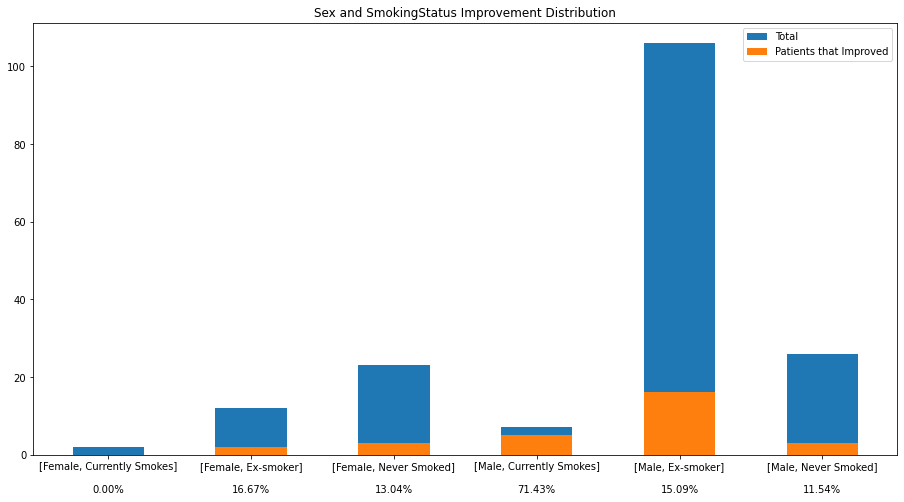

In [25]:
better = [FCbetter, FEbetter, FNbetter, MCbetter, MEbetter, MNbetter]
datalen = [len(FemaleC), len(FemaleE), len(FemaleN), len(MaleC), len(MaleE), len(MaleN)]
labels = ['[Female, Currently Smokes]\n', '[Female, Ex-smoker]\n', '[Female, Never Smoked]\n', \
          '[Male, Currently Smokes]\n', '[Male, Ex-smoker]\n', '[Male, Never Smoked]\n', ]
print(len(MaleC))
figure = plt.figure(figsize=(12,6))
ax = figure.add_axes([0,0,1,1])
ax.bar(['%s\n%.2f%%'%(labels[i],better[i]*100/datalen[i]) for i in range(6)], datalen, 0.5)
ax.bar(['%s\n%.2f%%'%(labels[i],better[i]*100/datalen[i]) for i in range(6)], better, 0.5, alpha=1)
ax.legend(labels=['Total', 'Patients that Improved'])
plt.title("Sex and SmokingStatus Improvement Distribution")
plt.show()

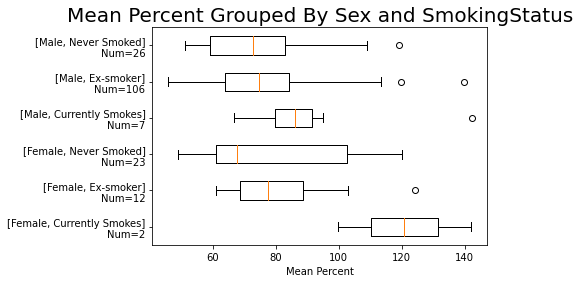

In [26]:
linreg = linear_model.LinearRegression()
MaleC, MaleE, MaleN, FemaleC, FemaleE, FemaleN = ([] for i in range(6))
Percentarray = []
for patient, info in list(train.groupby('Patient')):
    linreg.fit(info[['Weeks']], info[['FVC']])
    for i in range(len(info)):
        Percentarray.append(info.iloc[i]['Percent'])
    mean = sum(Percentarray)/len(Percentarray)
    if info.iloc[0]['Sex'] == 'Male':
        if info.iloc[0]['SmokingStatus'] == 'Currently smokes':
            MaleC.append(mean)
        elif info.iloc[0]['SmokingStatus'] == 'Ex-smoker':
            MaleE.append(mean)
        else:
            MaleN.append(mean)
    else:
        if info.iloc[0]['SmokingStatus'] == 'Currently smokes':
            FemaleC.append(mean)
        elif info.iloc[0]['SmokingStatus'] == 'Ex-smoker':
            FemaleE.append(mean)
        else:
            FemaleN.append(mean)
    Percentarray = []

data = [FemaleC, FemaleE, FemaleN, MaleC, MaleE, MaleN]
datalen = [len(FemaleC), len(FemaleE), len(FemaleN), len(MaleC), len(MaleE), len(MaleN)]
labels = ['[Female, Currently Smokes]\n', '[Female, Ex-smoker]\n', '[Female, Never Smoked]\n', \
          '[Male, Currently Smokes]\n', '[Male, Ex-smoker]\n', '[Male, Never Smoked]\n', ]
plot = plt.figure()
ax = plot.add_subplot()
boxplot = ax.boxplot(data, vert=False)
ax.set_yticklabels(['%sNum=%d'%(labels[i],datalen[i]) for i in range(6)])
ax.set_title('Mean Percent Grouped By Sex and SmokingStatus', fontsize=20)
ax.set_xlabel('Mean Percent')
plt.show()

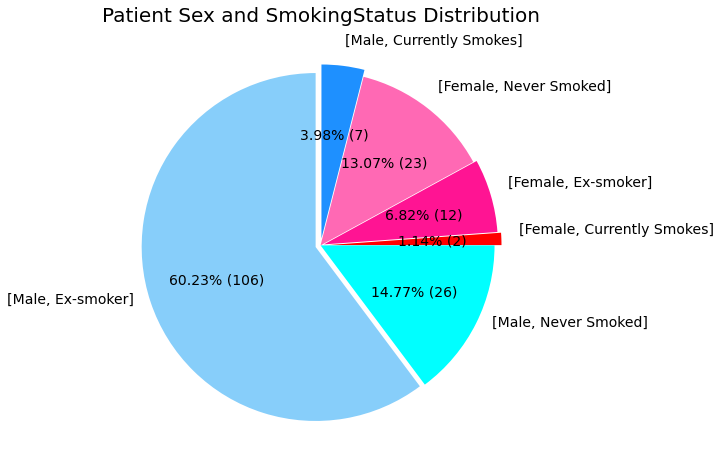

In [28]:
sizes = [len(FemaleC), len(FemaleE), len(FemaleN), len(MaleC), len(MaleE), len(MaleN)]
total = len(train['Patient'].unique())
labels = ['[Female, Currently Smokes]\n', '[Female, Ex-smoker]\n', '[Female, Never Smoked]\n', \
          '[Male, Currently Smokes]\n', '[Male, Ex-smoker]\n', '[Male, Never Smoked]\n', ]
colors = ['Red', 'DeepPink', 'HotPink', 'DodgerBlue', 'LightSkyBlue', 'Cyan']
explode = (0.04,0.02,0,0.04,0.03,0)
plt.figure(figsize=(14,8))
plt.pie(sizes, labels=labels, colors=colors, explode=explode, textprops={'fontsize': 14}, autopct=lambda p : '{:.2f}% ({:.0f})'.format(p, p*total/100))
plt.title("Patient Sex and SmokingStatus Distribution", fontsize=20)
plt.show()

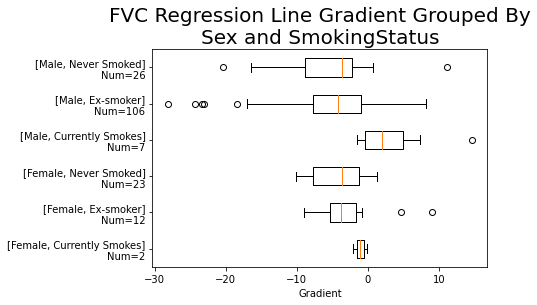

In [29]:
linreg = linear_model.LinearRegression()
MaleC, MaleE, MaleN, FemaleC, FemaleE, FemaleN = ([] for i in range(6))
MCgrad, MEgrad, MNgrad, FCgrad, FEgrad, FNgrad = ([] for i in range(6))
FVCarray = []
for patient, info in list(train.groupby('Patient')):
    linreg.fit(info[['Weeks']], info[['FVC']])
    for i in range(len(info)):
        FVCarray.append(info.iloc[i]['FVC'])
    mean = sum(FVCarray)/len(FVCarray)
    if info.iloc[0]['Sex'] == 'Male':
        if info.iloc[0]['SmokingStatus'] == 'Currently smokes':
            MaleC.append(mean)
            MCgrad.append(linreg.coef_[0][0])
        elif info.iloc[0]['SmokingStatus'] == 'Ex-smoker':
            MaleE.append(mean)
            MEgrad.append(linreg.coef_[0][0])
        else:
            MaleN.append(mean)
            MNgrad.append(linreg.coef_[0][0])
    else:
        if info.iloc[0]['SmokingStatus'] == 'Currently smokes':
            FemaleC.append(mean)
            FCgrad.append(linreg.coef_[0][0])
        elif info.iloc[0]['SmokingStatus'] == 'Ex-smoker':
            FemaleE.append(mean)
            FEgrad.append(linreg.coef_[0][0])
        else:
            FemaleN.append(mean)
            FNgrad.append(linreg.coef_[0][0])
    FVCarray = []

data = [FCgrad, FEgrad, FNgrad, MCgrad, MEgrad, MNgrad]
labels = ['[Female, Currently Smokes]\n', '[Female, Ex-smoker]\n', '[Female, Never Smoked]\n', \
          '[Male, Currently Smokes]\n', '[Male, Ex-smoker]\n', '[Male, Never Smoked]\n', ]
plot = plt.figure()
ax = plot.add_subplot()
boxplot = ax.boxplot(data, vert=False)
ax.set_yticklabels(['%sNum=%d'%(labels[i],datalen[i]) for i in range(6)])
ax.set_title('FVC Regression Line Gradient Grouped By\nSex and SmokingStatus', fontsize=20)
ax.set_xlabel('Gradient')
plt.show()

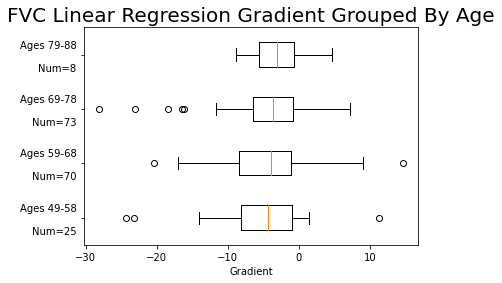

In [30]:
linreg = linear_model.LinearRegression()
age4958, age5968, age6978, age7988 = ([] for i in range(4))
grad4958, grad5968, grad6978, grad7988 = ([] for i in range(4))
FVCarray = []
for patient, info in list(train.groupby('Patient')):
    linreg.fit(info[['Weeks']], info[['FVC']])
    for i in range(len(info)):
        FVCarray.append(info.iloc[i]['FVC'])
    mean = sum(FVCarray)/len(FVCarray)
    if info.iloc[0]['Age'] in range(49,59):
        age4958.append(mean)
        grad4958.append(linreg.coef_[0][0])
    elif info.iloc[0]['Age'] in range(59,69):
        age5968.append(mean)
        grad5968.append(linreg.coef_[0][0])
    elif info.iloc[0]['Age'] in range(69,79):
        age6978.append(mean)
        grad6978.append(linreg.coef_[0][0])
    else: 
        age7988.append(mean)
        grad7988.append(linreg.coef_[0][0])
    FVCarray = []

data = [grad4958, grad5968, grad6978, grad7988]
datalen = [len(grad4958), len(grad5968), len(grad6978), len(grad7988)]
labels = ['Ages 49-58\n', 'Ages 59-68\n', 'Ages 69-78\n', 'Ages 79-88\n']
plot = plt.figure()
ax = plot.add_subplot()
boxplot = ax.boxplot(data, vert=False)
ax.set_yticklabels(['%s\nNum=%d'%(labels[i],datalen[i]) for i in range(4)])
ax.set_title('FVC Linear Regression Gradient Grouped By Age', fontsize=20)
ax.set_xlabel('Gradient')
plt.show()

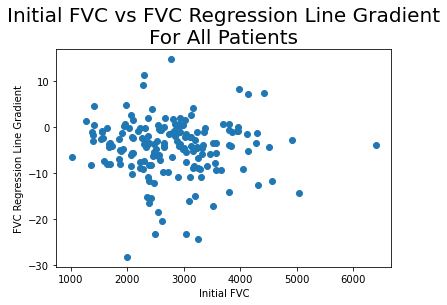

In [31]:
linreg = linear_model.LinearRegression()
initialFVC = []
gradients = []
for patient, info in list(train.groupby('Patient')):
    linreg.fit(info[['Weeks']], info[['FVC']])
    initialFVC.append(info.iloc[0]['FVC'])
    gradients.append(linreg.coef_[0][0])

plt.scatter(x=initialFVC, y=gradients)
plt.ylabel('FVC Regression Line Gradient', fontsize=10)
plt.xlabel('Initial FVC', fontsize=10)
plt.title('Initial FVC vs FVC Regression Line Gradient\nFor All Patients', fontsize=20)
plt.show()

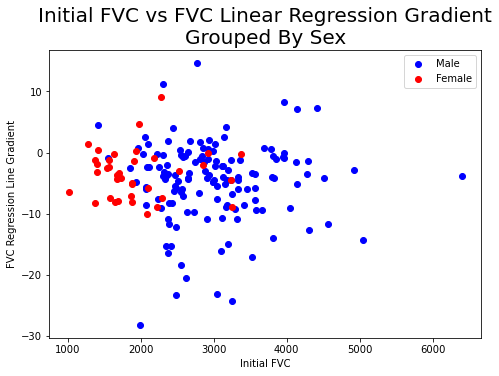

In [32]:
linreg = linear_model.LinearRegression()
initialFVCM, initialFVCF = [], []
gradientsM, gradientsF = [], []
FVCarray = []
for patient, info in list(train.groupby('Patient')):
    linreg.fit(info[['Weeks']], info[['FVC']])
    if info.iloc[0]['Sex'] == 'Male':
        initialFVCM.append(info.iloc[0]['FVC'])
        gradientsM.append(linreg.coef_[0][0])
    else:
        initialFVCF.append(info.iloc[0]['FVC'])
        gradientsF.append(linreg.coef_[0][0])

figure = plt.figure()
ax = figure.add_axes([0,0,1,1])
plt.scatter(x=initialFVCM, y=gradientsM, c ='blue')
plt.scatter(x=initialFVCF, y=gradientsF, c = 'red')
plt.title('Initial FVC vs FVC Linear Regression Gradient\nGrouped By Sex', fontsize=20)
plt.ylabel('FVC Regression Line Gradient', fontsize=10)
plt.xlabel('Initial FVC', fontsize=10)
ax.legend(labels=['Male', 'Female'])
plt.show()

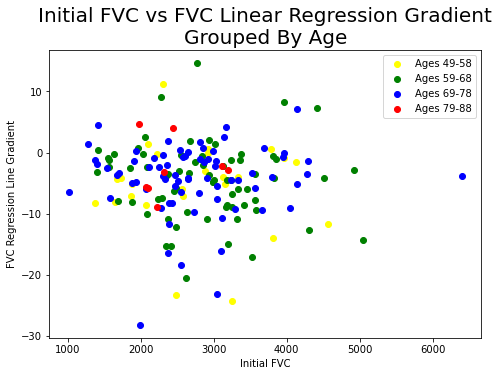

In [33]:
linreg = linear_model.LinearRegression()
initialFVC4, initialFVC5, initialFVC6, initialFVC7 = ([] for i in range(4))
gradients4, gradients5, gradients6, gradients7 = ([] for i in range(4))
FVCarray = []
for patient, info in list(train.groupby('Patient')):
    linreg.fit(info[['Weeks']], info[['FVC']])
    if info.iloc[0]['Age'] in range(49,59):
        initialFVC4.append(info.iloc[0]['FVC'])
        gradients4.append(linreg.coef_[0][0])
    elif info.iloc[0]['Age'] in range(59,69):
        initialFVC5.append(info.iloc[0]['FVC'])
        gradients5.append(linreg.coef_[0][0])
    elif info.iloc[0]['Age'] in range(69,79):
        initialFVC6.append(info.iloc[0]['FVC'])
        gradients6.append(linreg.coef_[0][0])
    else: 
        initialFVC7.append(info.iloc[0]['FVC'])
        gradients7.append(linreg.coef_[0][0])

figure = plt.figure()
ax = figure.add_axes([0,0,1,1])
plt.scatter(x=initialFVC4, y=gradients4, c = 'yellow' )
plt.scatter(x=initialFVC5, y=gradients5, c = 'green')
plt.scatter(x=initialFVC6, y=gradients6, c = 'blue')
plt.scatter(x=initialFVC7, y=gradients7, c = 'red')
plt.title('Initial FVC vs FVC Linear Regression Gradient\nGrouped By Age', fontsize=20)
plt.ylabel('FVC Regression Line Gradient', fontsize=10)
plt.xlabel('Initial FVC', fontsize=10)
ax.legend(labels=['Ages 49-58', 'Ages 59-68', 'Ages 69-78', 'Ages 79-88'])
plt.show()

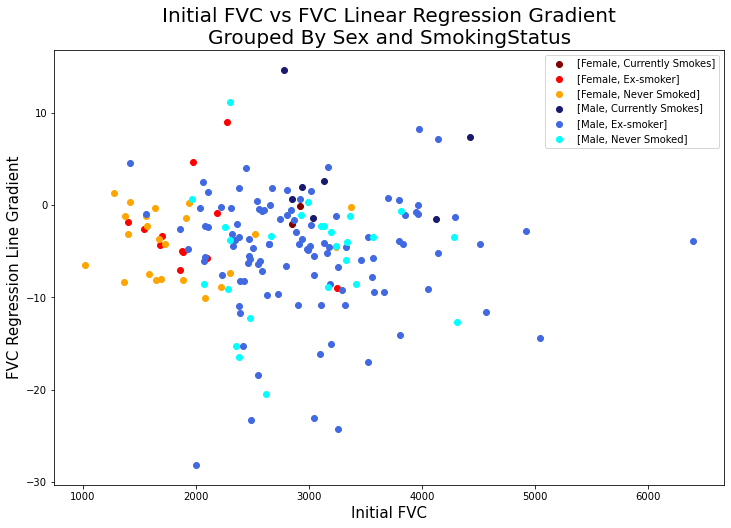

In [34]:
linreg = linear_model.LinearRegression()
MaleC, MaleE, MaleN, FemaleC, FemaleE, FemaleN = ([] for i in range(6))
MCgrad, MEgrad, MNgrad, FCgrad, FEgrad, FNgrad = ([] for i in range(6))
FVCarray = []
for patient, info in list(train.groupby('Patient')):
    linreg.fit(info[['Weeks']], info[['FVC']])
    if info.iloc[0]['Sex'] == 'Male':
        if info.iloc[0]['SmokingStatus'] == 'Currently smokes':
            MaleC.append(info.iloc[0]['FVC'])
            MCgrad.append(linreg.coef_[0][0])
        elif info.iloc[0]['SmokingStatus'] == 'Ex-smoker':
            MaleE.append(info.iloc[0]['FVC'])
            MEgrad.append(linreg.coef_[0][0])
        else:
            MaleN.append(info.iloc[0]['FVC'])
            MNgrad.append(linreg.coef_[0][0])
    else:
        if info.iloc[0]['SmokingStatus'] == 'Currently smokes':
            FemaleC.append(info.iloc[0]['FVC'])
            FCgrad.append(linreg.coef_[0][0])
        elif info.iloc[0]['SmokingStatus'] == 'Ex-smoker':
            FemaleE.append(info.iloc[0]['FVC'])
            FEgrad.append(linreg.coef_[0][0])
        else:
            FemaleN.append(info.iloc[0]['FVC'])
            FNgrad.append(linreg.coef_[0][0])
    FVCarray = []

labels = ['[Female, Currently Smokes]', '[Female, Ex-smoker]', '[Female, Never Smoked]', \
          '[Male, Currently Smokes]', '[Male, Ex-smoker]', '[Male, Never Smoked]']
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.scatter(x=FemaleC, y=FCgrad, c = 'maroon')
ax.scatter(x=FemaleE, y=FEgrad, c = 'red')
ax.scatter(x=FemaleN, y=FNgrad, c = 'orange')

ax.scatter(x=MaleC, y=MCgrad, c = 'midnightblue')
ax.scatter(x=MaleE, y=MEgrad, c = 'royalblue')
ax.scatter(x=MaleN, y=MNgrad, c = 'cyan')
plt.title('Initial FVC vs FVC Linear Regression Gradient\nGrouped By Sex and SmokingStatus', fontsize=20)
plt.ylabel('FVC Regression Line Gradient', fontsize=15)
plt.xlabel('Initial FVC', fontsize=15)
ax.legend(labels=labels)
plt.show()